# Online VMP of AR(p)
State space model
\begin{align*}
    &\mathbf{x}_t = \mathbf{A}\mathbf{x}_{t-1} + \mathbf{p}_t \quad \mathbf{p}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma_t^{-1}) \\
    &y_t = \mathbf{c}^\text{T}\mathbf{x}_t + m_t \quad m_t \sim \mathcal{N}(0, \epsilon)
\end{align*}

or

\begin{align*}
     &p(\mathbf{x}_t\,|\,\mathbf{x}_{t-1},\mathbf{a},\gamma) = \mathcal{N}\left(\mathbf{x}_t \;\middle|\; \mathbf{A}\mathbf{x}_{t-1}, \mathbf{I}\gamma^{-1} \right)\\
    &p(y_t\,|\,\mathbf{x}_{t}) = \mathcal{N}\left(y_t \;\middle|\;\mathbf{c}^\text{T}\mathbf{x}_t, \epsilon \right)
\end{align*}

where

\begin{align*}
    &\mathbf{x}_t = (x_t, x_{t-1}, \dots, x_{t-p+1})^\text{T} \quad \mathbf{x}_{t-1} = (x_{t-1}, x_{t-2}, \dots, x_{t-p})^\text{T} 
    \\ \\
    &\mathbf{A} = 
    \begin{bmatrix}
        a_1 & a_2 & a_3 & \dots & a_p \\
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 0
    \end{bmatrix}
    =
    \begin{bmatrix}
         \mathbf{a}^\text{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \\ \\
    &\mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix} \\
    &\epsilon = 1\text{e}-12
\end{align*}

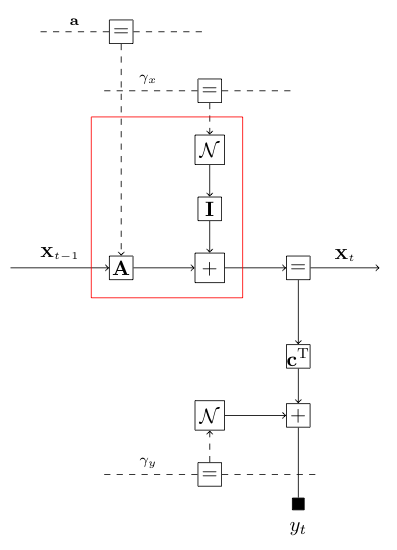

In [17]:
using Images
img = load("../ffgs/HAR-online.png")

We are interested in an estimation of the AR coefficients $\mathbf{a}$, while setting process noise precision $\gamma=1$.

In [44]:
using ProgressMeter
using Revise
using ForneyLab
using Random
include( "../AR-node/autoregression.jl")
include("../AR-node/rules_prototypes.jl")
include("../AR-node/vmp_rules.jl")
# helpers for evaluation of the model
include("../helpers/functions.jl")
# module to generate data for AR
include("../data/ARdata.jl")
import Main.ARdata: loadAR, generateAR, writeAR, readAR
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [45]:
Random.seed!(42)

# Define the order and data
ARorder = 2
diagAR(dim) = Matrix{Float64}(I, dim, dim)

# AR data
v_x = 0.1 # process noise variance
coefs, data = generateAR(1000, ARorder, 1.0, noise_variance=v_x)

# Observations
y = [x[1] for x in data[ARorder + 1:end]]

998-element Array{Float64,1}:
 -0.4865497344608723  
  0.253825999548418   
  0.546696013252733   
 -0.3005401801577731  
 -0.35607691315973033 
  0.5480217549889482  
 -0.6494657225684641  
  0.24744865135774297 
 -0.11977793634288628 
 -0.3757138063853248  
  0.42090576079646097 
 -0.13545757699720073 
 -0.3351164310797603  
  ⋮                   
  0.14153880635324717 
  0.8663938265656579  
 -0.2768054811278391  
 -0.4337430635176242  
  0.5627682188816185  
 -0.29849647184868766 
  0.23442825306927675 
 -0.022597430674915955
 -0.18202063812491762 
  0.01381595412835937 
 -0.04195753137548054 
  0.006466777454646799

In [46]:
g = FactorGraph()

# declare priors as random variables
@RV m_x_t_prev
@RV w_x_t_prev
@RV m_a_t
@RV w_a_t
@RV m_y_t
@RV a_w_t
@RV b_w_t

@RV a ~ GaussianMeanPrecision(m_a_t, w_a_t)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV w ~ Gamma(a_w_t, b_w_t)
@RV x_t = AR(a, x_t_prev, w)
c = zeros(ARorder); c[1] = 1.0
@RV y_t ~ GaussianMeanPrecision(m_y_t, huge)
DotProduct(y_t, c, x_t)

# Placeholders for prior
placeholder(m_a_t, :m_a_t, dims=(ARorder,))
placeholder(w_a_t, :w_a_t, dims=(ARorder, ARorder))
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))
placeholder(a_w_t, :a_w_t)
placeholder(b_w_t, :b_w_t)

# Placeholder for data
placeholder(m_y_t, :m_y_t)

ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 1976529848311539305 -->
 
 1976529848311539305 
 
 placeholder_m_x_t_prev 
 
<!-- 4470858784549513272 -->
 
 4470858784549513272 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 1976529848311539305--4470858784549513272 -->
 
 1976529848311539305--4470858784549513272 
 
 m_x_t_prev 
 2 m 
 1 out 
 
<!-- 16484458098224052219 -->
 
 16484458098224052219 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 9080151752690018048 -->
 
 9080151752690018048 
 
 placeholder_m_y_t 
 
<!-- 18426690444341798006 -->
 
 18426690444341798006 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 9080151752690018048--18426690444341798006 -->
 
 9080151752690018048--18426690444341798006 
 
 m_y_t 
 2 m 
 1 out 
 
<!-- 1020475148593581403 -->
 
 1020475148593581403 
 
 clamp_2 
 
<!-- 16998706221831961686 -->
 
 16998706221831961686 
 
 placeholder_w_a_t 
 
<!-- 16998706221831961686--16484458098224052219 -->
 
 16998706221831961686--16484458098224052219 
 
 w_a_t 
 3 w 
 1 out 
 
<!-- 681287154118492545 -->
 
 681287154118492545 
 
 clamp_1 
 
<!-- 18426690444341798006--681287154118492545 -->
 
 18426690444341798006--681287154118492545 
 
 clamp_1 
 1 out 
 3 w 
 
<!-- 12954319238826534346 -->
 
 12954319238826534346 
 
 placeholder_m_a_t 
 
<!-- 12954319238826534346--16484458098224052219 -->
 
 12954319238826534346--16484458098224052219 
 
 m_a_t 
 2 m 
 1 out 
 
<!-- 4284033838430395587 -->
 
 4284033838430395587 
 
 dot 
 dotproduct_1 
 
<!-- 4284033838430395587--1020475148593581403 -->
 
 4284033838430395587--1020475148593581403 
 
 clamp_2 
 1 out 
 2 in1 
 
<!-- 4284033838430395587--18426690444341798006 -->
 
 4284033838430395587--18426690444341798006 
 
 y_t 
 1 out 
 1 out 
 
<!-- 17322365252962102980 -->
 
 17322365252962102980 
 
 Autoregression 
 autoregression_1 
 
<!-- 4284033838430395587--17322365252962102980 -->
 
 4284033838430395587--17322365252962102980 
 
 x_t 
 1 out 
 3 in2 
 
<!-- 5505918065801855053 -->
 
 5505918065801855053 
 
 placeholder_w_x_t_prev 
 
<!-- 5505918065801855053--4470858784549513272 -->
 
 5505918065801855053--4470858784549513272 
 
 w_x_t_prev 
 3 w 
 1 out 
 
<!-- 6664183478779402128 -->
 
 6664183478779402128 
 
 placeholder_b_w_t 
 
<!-- 2869092291011617289 -->
 
 2869092291011617289 
 
 Gam 
 gamma_1 
 
<!-- 6664183478779402128--2869092291011617289 -->
 
 6664183478779402128--2869092291011617289 
 
 b_w_t 
 3 b 
 1 out 
 
<!-- 7395542931328282804 -->
 
 7395542931328282804 
 
 placeholder_a_w_t 
 
<!-- 7395542931328282804--2869092291011617289 -->
 
 7395542931328282804--2869092291011617289 
 
 a_w_t 
 2 a 
 1 out 
 
<!-- 17322365252962102980--4470858784549513272 -->
 
 17322365252962102980--4470858784549513272 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 17322365252962102980--16484458098224052219 -->
 
 17322365252962102980--16484458098224052219 
 
 a 
 1 out 
 3 a 
 
<!-- 17322365252962102980--2869092291011617289 -->
 
 17322365252962102980--2869092291011617289 
 
 w 
 1 out 
 4 W

In [47]:
# Specify recognition factorization
q = RecognitionFactorization(a, x_t, w, ids=[:A :X_t :W])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))

stepX_t! (generic function with 3 methods)

In [48]:
# Define values for prior statistics
m_a_0 = zeros(ARorder)
w_a_0 = 0.001*diagAR(ARorder)
m_x_prev_0 = ones(ARorder)
w_x_prev_0 = diagAR(ARorder)
a_w_0 = 3
b_w_0 = 1

# Storage for predictions
means = []
vars = []

# Storage for MSE of test set
MSEs = []
upto = ARorder
# we exclude last p (ARorder) samples for model evaluation purposes
n_samples = length(y) - upto 

# Storage
m_x = Vector{Vector{Float64}}(undef, n_samples)
w_x = Vector{Array{Float64, 2}}(undef, n_samples)
m_a = Vector{Vector{Float64}}(undef, n_samples)
w_a = Vector{Array{Float64, 2}}(undef, n_samples)
a_w = Vector{Float64}(undef, n_samples)
b_w = Vector{Float64}(undef, n_samples)

# Inits
m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
m_a_min = m_a_0
w_a_min = w_a_0
a_w_min = a_w_0
b_w_min = b_w_0;

In [49]:
marginals = Dict()
# VMP iterations
n_its = 10

# making first dummy predictions
push!(means, m_a_min'm_x_t_prev_min)
push!(vars, a_w_t_min/b_w_t_min)

p = Progress(length(y), 1, "Observed ")
window = 5

for t in 1:n_samples
    predictions = predict(m_a_min, m_x_t_prev_min, ARorder)
    push!(MSEs, mse(predictions, y[t:t+upto-1]))
    update!(p, t)
    marginals[:a] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_a_min, w=w_a_min)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w_t_min, b=b_w_t_min)
    global m_x_t_prev_min, w_x_t_prev_min, m_a_min, w_a_t_min, a_w_t_min, b_w_t_min
    for i = 1:n_its
        data = Dict(:m_y_t => y[t],
                    :m_a_t => m_a_min,
                    :w_a_t => w_a_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min,
                    :a_w_t => a_w_t_min,
                    :b_w_t => b_w_t_min)
        stepX_t!(data, marginals)
        stepA!(data, marginals)
        stepW!(data, marginals)
        m_a[t] = unsafeMean(marginals[:a])
        w_a[t] = unsafePrecision(marginals[:a])
        m_x[t] = unsafeMean(marginals[:x_t])
        w_x[t] = unsafePrecision(marginals[:x_t])
        a_w[t] = marginals[:w].params[:a]
        b_w[t] = marginals[:w].params[:b]
        m_a_min = m_a[t]
        w_a_min = w_a[t]
        m_x_t_prev_min = m_x[t]
        w_x_t_prev_min = w_x[t]
        a_w_t_min = a_w[t]
        b_w_t_min = b_w[t]
    end
    # prediction of the next value
    m = m_a_min'm_x_t_prev_min
    v = mean(marginals[:w])^-1
    push!(means, m)
    push!(vars, v)
end

Observed  59%|████████████████████████▋                 |  ETA: 0:00:01

In [50]:
println("Coefs")
println("real = ", coefs)
println("estimated mean = ", unsafeMean(marginals[:a]))
println("===============")
println("Noise")
println("real variance = ", v_x)
println("estimated variance = ", unsafeMean(marginals[:w])^-1)

Coefs
real = [-0.556027, -0.444383]
estimated mean = [-0.450732, -0.230182]
Noise
real variance = 0.1
estimated variance = 0.11098260719573949


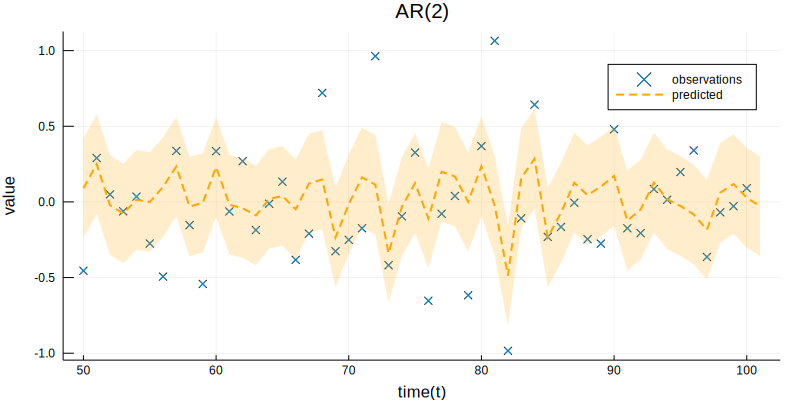

In [51]:
using Plots

from = 50
upto = 100
scale = 1.0


scatter(collect(from:upto), y[from:upto], label="observations", title="AR($ARorder)", size=(800, 400), 
        markershape = :xcross, markeralpha = 0.9, markersize = 3)
pAR1 = plot!(collect(from:upto+1), means[from:upto+1], ribbon=(sqrt.(vars[from:upto+1]), sqrt.(vars[from:upto+1])),
          linestyle=:dash, linewidth = 2,
          color=:orange,
          fillalpha = 0.2,
          fillcolor = :orange,
          label="predicted", xlabel="time(t)", ylabel="value",
          legend=true)

In [52]:
# Amimation
# Plotting predictions
toshow = 10 # number of points to plot at once (length(predictions) - length(y) = 1)
scale = 1.0 # scale for the variance

anim = @animate for i in 1:length(means)-toshow-1
    s = plot(xticks = i:div(toshow, 2):i+toshow);
    ylims!(minimum(y) - .1, maximum(y) + .1);
    plot!(collect(i:i+toshow), y[i:i+toshow], xlabel="observation", ylabel="value", label="actual", color=:blue)
    plot!(collect(i:i+toshow+1), means[i:i+toshow+1], ribbon=(sqrt.(vars[i:i+toshow+1]), sqrt.(vars[i:i+toshow+1])),
          linestyle=:dash, linewidth = 2,
          color=:orange,
          fillalpha = 0.2,
          fillcolor = :orange,
          label="predicted")
end;

In [53]:
gif(anim, "../gifs/predictions.gif", fps = 5)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/predictions.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/predictions.gif")

In [54]:
# Plotting MSE
anim = @animate for i in 1:length(MSEs)
    s = plot()
    ylims!(minimum(MSEs) - 1, maximum(MSEs) + 1)
    xlims!(1, length(MSEs))
    plot!(collect(1:i), MSEs[1:i], xlabel="observation", ylabel="MSE", label="")
end;

In [55]:
gif(anim, "../gifs/MSE_evo.gif", fps = 100)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/MSE_evo.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/MSE_evo.gif")

In [56]:
# Plotting AR coefs
# !!! ONLY FOR AR(2)
using LinearAlgebra; 

len = 64

# Definition of the bivariate gaussian using a covariance matrix
𝓝(x, μ, Σ) = 1/((2 * π)^(length(μ)/2) * det(Σ)^(1/2)) * exp(-(1/2) * (x-μ)' * Σ^(-1) * (x-μ));

insert!(m_a, 1, m_a_0)
insert!(w_a, 1, 0.1*diagAR(ARorder))
anim = @animate for i in 1:1:length(m_a)
    if !isassigned(m_a, i)
        continue
    end
    s = plot();
    xlims!(-0.1, 1.3)
    ylims!(-1.2, 0.2)
    plot!([m_a_0[1]],[m_a_0[2]], seriestype=:scatter, title = "AR coefs", label="prior")
    plot!([coefs[1]],[coefs[2]], seriestype=:scatter, label="true")
    plot!([m_a[i][1]],[m_a[i][2]], seriestype=:scatter, label="posterior")
    
    # Posterior
    # get the maximum σ (used to construct the x and y ranges)
    σ_max = sqrt((w_a[i][1]^-1 > w_a[i][4]^-1 ) ? w_a[i][1]^-1 : w_a[i][4]^-1)
    rx = range(m_a[i][1]-3*σ_max, m_a[i][1]+3*σ_max, length=len)
    ry = range(m_a[i][2]-3*σ_max, m_a[i][2]+3*σ_max, length=len)
    contour!(rx, ry, (x1, x2) -> 𝓝([x1 ; x2], m_a[i], w_a[i]^-1), xlabel="a1", ylabel="a2")
end;

In [57]:
gif(anim, "../gifs/kpcoefs_evo.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/kpcoefs_evo.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/kpcoefs_evo.gif")

# Random walk model 
As a benchamrk, we use the following RW model.
\begin{align*}
    &x_t = x_{t-1} + p_t \quad p_t \sim \mathcal{N}(0, \gamma_x^{-1}) \\
\end{align*}

We set $\gamma_y = 1.0$

In [58]:
function rwp_predict(x, pn_var, upto)
    predictions = []
    for i in 1:upto
        x̂ = x + sqrt(pn_var)*randn()
        push!(predictions, x̂)
        x = x
    end
    return predictions
end

pn_var = 10.0
rw = y[1:n_samples] #.+ sqrt(pn_var)*randn()

MSEs_rw = []
upto = ARorder
for t in 1:n_samples
    predictions = rwp_predict(rw[t], 1.0, upto)
    push!(MSEs_rw, mse(predictions, y[t:t+upto-1]))
end

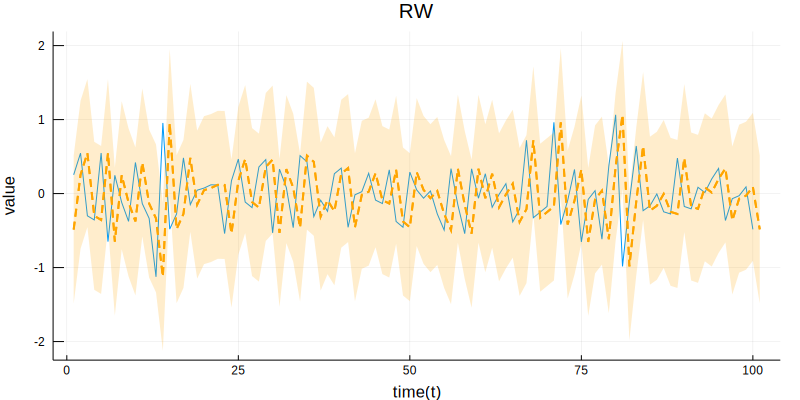

In [59]:
using Plots

from = 1
upto = 100
var_rw = 1.0
plot(y[from + 1:upto + 1], xlabel="time(t)", ylabel="value", label="actual", title="RW", size=(800, 400))

pRW = plot!(collect(from:upto+1), [rw[from:upto+1], rw[from:upto+1]], fillrange=[rw[from:upto+1] .-
            var_rw, rw[from:upto+1] .+ var_rw],
            linestyle=:dash, linewidth = 2,
            color=:orange,
            fillalpha = 0.2,
            fillcolor = :orange,
            label="predicted",
            legend=false)

# Comparison

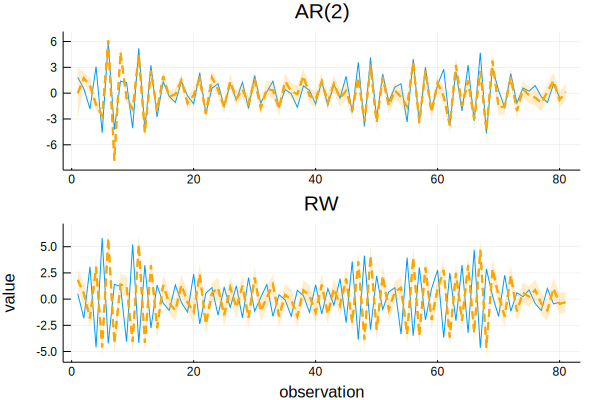

In [11]:
using Plots

from = 1
upto = 80
var_rw = 1.0
plot(y[from + 1:upto + 1], xlabel="observation", ylabel="value", label="actual", title="RW")
pRW = plot!(collect(from:upto+1), [rw[from:upto+1], rw[from:upto+1]], fillrange=[rw[from:upto+1] .-
            var_rw, rw[from:upto+1] .+ var_rw],
            linestyle=:dash, linewidth = 2,
            color=:orange,
            fillalpha = 0.2,
            fillcolor = :orange,
            label="predicted")

plot(y[from:upto], label="actual", title="AR($ARorder)")
#pAR = plot!(means[from:upto], label="predicted")
pAR = plot!(collect(from:upto+1), [means[from:upto+1], means[from:upto+1]], fillrange=[means[from:upto+1] -
          scale .* vars[from:upto+1], means[from:upto+1] + scale .* vars[from:upto+1]],
          linestyle=:dash, linewidth = 2,
          color=:orange,
          fillalpha = 0.2,
          fillcolor = :orange,
          label="predicted")
plot(pAR, pRW, layout=(2,1), legend=false)

To assess the performance of our model, we use the following metric:
$$\frac{1}{p}\sum_{i=1}^p(\hat{x}_{T+i}-x_{T+i})^2$$
where
\begin{align*}
&\hat{x}_{T+1}=\sum_{i=1}^p m_{a_{i}}x_{T-i} \\
&\hat{x}_{T+2}=\sum_{i=1}^{p-1} m_{a_{i}}x_{T-i}+m_{a_{p}}\hat{x}_{T+1} \\
&\hat{x}_{T+3}=\sum_{i=1}^{p-2} m_{a_{i}}x_{T-i}+m_{a_{p}}\hat{x}_{T+2}+m_{a_{p-1}}\hat{x}_{T+1} \\
&\qquad \vdots \\ 
&\hat{x}_{T+p+1}=\sum_{i=1}^{p}m_{a_{i}}\hat{x}_{T+p-i} 
\end{align*}

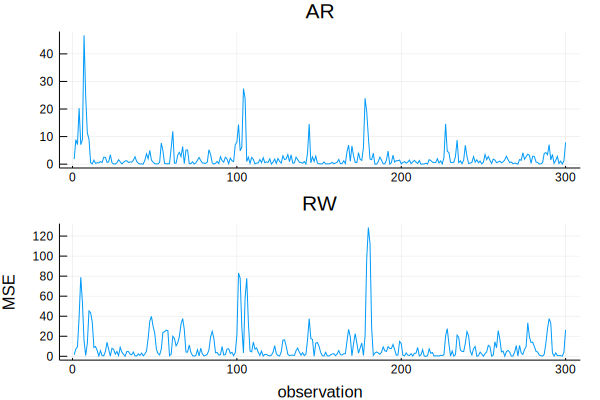

In [12]:
from = 1
upto = 300
pRW = plot(MSEs_rw[from:upto], xlabel="observation", ylabel="MSE", label="", title="RW")
pAR = plot(MSEs[from:upto], label="",  title="AR")
plot(pAR, pRW, layout=(2,1))

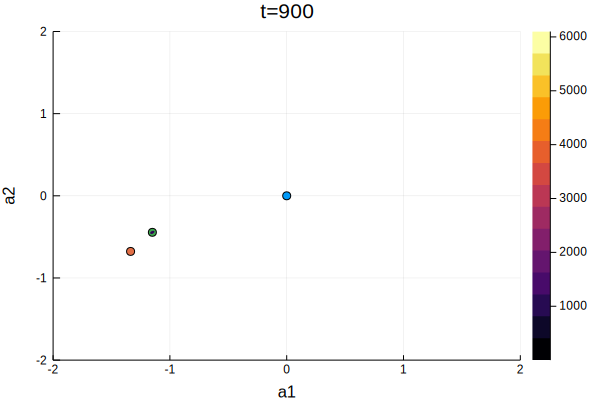

In [20]:
using LinearAlgebra; 

i=900

len = 64

# Definition of the bivariate gaussian using a covariance matrix
𝓝(x, μ, Σ) = 1/((2 * π)^(length(μ)/2) * det(Σ)^(1/2)) * exp(-(1/2) * (x-μ)' * Σ^(-1) * (x-μ));
s = plot();
xlims!(-2, 2)
ylims!(-2, 2)
plot!([m_a_0[1]],[m_a_0[2]], seriestype=:scatter, title = "t=$i", label="prior")
plot!([coefs[1]],[coefs[2]], seriestype=:scatter, label="true")
plot!([m_a[i][1]],[m_a[i][2]], seriestype=:scatter, label="posterior")

# Posterior
# get the maximum σ (used to construct the x and y ranges)
σ_max = sqrt((w_a[i][1]^-1 > w_a[i][4]^-1 ) ? w_a[i][1]^-1 : w_a[i][4]^-1)
rx = range(m_a[i][1]-3*σ_max, m_a[i][1]+3*σ_max, length=len)
ry = range(m_a[i][2]-3*σ_max, m_a[i][2]+3*σ_max, length=len)
contour!(rx, ry, (x1, x2) -> 𝓝([x1 ; x2], m_a[i], w_a[i]^-1), xlabel="a1", ylabel="a2", legend=:false)